# Building a brain object

Brain objects are supereeg’s fundamental data structure for a single subject’s ECoG data. To create one at minimum you’ll need a matrix of neural recordings (time samples by electrodes), electrode locations, and a sample rate. Additionally, you can include information about separate recording sessions and store custom meta data. In this tutorial, we’ll build a brain object from scratch and get familiar with some of the methods.

# Load in the required libraries

In [1]:
import supereeg as se
import numpy as np
import warnings
import os
import gzip
from nibabel.testing import data_path
example_ni1 = os.path.join(data_path, 'example4d.nii.gz')
warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Simulate some data

First, we’ll use supereeg’s built in simulation functions to simulate some data and electrodes. By default, the simulate_data function will return a 1000 samples by 10 electrodes matrix, but you can specify the number of time samples with n_samples and the number of electrodes with n_elecs. If you want further information on simulating data, check out the simulate tutorial!

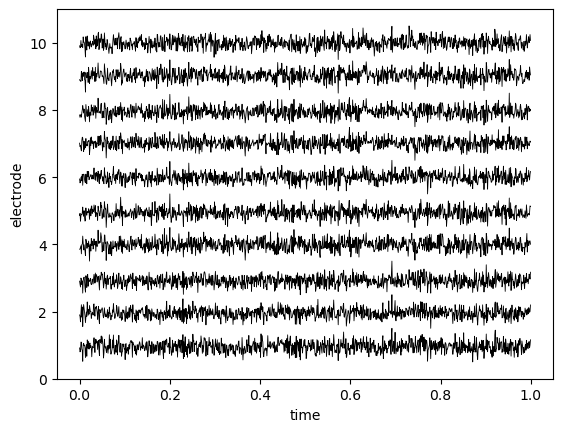

In [2]:
# simulate some data
bo_data = se.simulate_bo(n_samples=1000, sessions=2, n_elecs=10)

# plot it
bo_data.plot_data()

# get just data
data = bo_data.get_data()

We’ll also simulate some electrode locations

In [3]:
locs = se.simulate_locations()
print(locs)

    x   y   z
0 -30 -49 -47
1 -18  26  17
2 -15  37   9
3  20  23  41
4  21  38 -36
5  26 -18   2
6  44  43 -21
7  44  47   9
8  46   7 -12
9  48  17   0


# Creating a brain object

To construct a new brain objects, simply pass the data and locations to the Brain class like this:

In [4]:
bo = se.Brain(data=data, locs=locs, sample_rate=100)

To view a summary of the contents of the brain object, you can call the info function:

In [5]:
bo.info()

Number of electrodes: 10
Recording time in seconds: [10.]
Sample Rate in Hz: [100]
Number of sessions: 1
Date created: Mon Jan 13 17:29:07 2025
Meta data: {}


Optionally, you can pass a sessions parameter, which is can be a numpy array or list the length of your data with a unique identifier for each session. For example:

In [6]:
sessions = np.array([1]*(data.shape[0]//2)+[2]*(data.shape[0]//2))
bo = se.Brain(data=data, locs=locs, sample_rate=1000, sessions=sessions)
bo.info()

Number of electrodes: 10
Recording time in seconds: [0.5 0.5]
Sample Rate in Hz: [1000, 1000]
Number of sessions: 2
Date created: Mon Jan 13 17:29:09 2025
Meta data: {}


You can also add custom meta data to the brain object to help keep track of its contents. meta is a dictionary comprised of whatever you want:

In [7]:
meta = {
    'subjectID' : '123',
    'Investigator' : 'Andy',
    'Hospital' : 'DHMC'
}
bo = se.Brain(data=data, locs=locs, sample_rate=1000, sessions=sessions, meta=meta)
bo.info()

Number of electrodes: 10
Recording time in seconds: [0.5 0.5]
Sample Rate in Hz: [1000, 1000]
Number of sessions: 2
Date created: Mon Jan 13 17:29:09 2025
Meta data: {'subjectID': '123', 'Investigator': 'Andy', 'Hospital': 'DHMC'}


# Initialize brain objects

Brain objects can be initialized by passing any of the following to the Brain class instance initialization function: 

- A path to a saved Brain object (ending in .bo)
- An existing Brain object (this creates a copy of the object)
- A path to or instance of any other supported toolbox type (Model objects or .mo files, or Nifti objects or .nii files)

In addition, Brain objects may be created via load by specifying return_type='bo'.

For example:

In [8]:
with gzip.open(example_ni1) as f:
    nii_bo = se.Brain(f)

TypeError: unsupported operand type(s) for /: 'bytes' and 'int'

Or:

In [9]:
nii_bo = se.load('example_ni1', return_type='bo')

ValueError: Filetype not recognized. Must be .bo, .mo or .nii.

Another feature, which can be particularly useful when working with large files, is loading only a subfield by specifiying field. For example, if you only want to load locations:

In [10]:
bo_locs = se.load('example_data', field='locs')

# The structure of a brain object

Inside the brain object, the ECoG data are stored in a Pandas DataFrame that can be accessed with the get_data function:

In [11]:
bo.get_data().head()

,0,1,2,3,4,5,6,7,8,9
0,-0.176192,-0.310884,-0.042164,-0.784436,-0.462506,-0.230489,-0.006690,-0.489663,-0.567773,-0.383980
1,-0.700823,-0.560049,-0.503448,-0.754641,-0.140072,-0.737975,-0.721150,-0.834852,-0.694695,-0.631175
2,-0.571064,-1.442224,-0.852440,-0.497217,-1.367218,-0.600803,-0.472301,-0.510505,-0.717639,-0.607660
3,0.599586,0.003766,0.391156,-0.212291,-0.562167,-0.046923,-1.172904,-0.439634,-0.797921,0.308853
4,0.580912,1.368717,0.238012,-1.540940,-0.296683,0.063905,-1.606867,-0.796209,0.524854,-0.469043


Similarly, the electrode locations are stored as a Pandas DataFrame, and can be retrieved using the get_locs method:

In [12]:
bo.get_locs().head()

,x,y,z
0,-30,-49,-47
1,-18,26,17
2,-15,37,9
3,20,23,41
4,21,38,-36


Brain objects are iterable, so you index a brain object like this:

In [13]:
#return first time sample
bo[0]
#return first 3 time samples
bo[:3]
#return first electrode
bo[:, 0]
#returns first 3 timesamples/elecs
bo_i = bo[:3, :3]
bo_i.get_data()

,0,1,2
0,-0.176192,-0.310884,-0.042164
1,-0.700823,-0.560049,-0.503448
2,-0.571064,-1.442224,-0.852440


You can also pass a list of indices for either times (sample numbers) or locs to the get_slice method and return a subset of the brain object.

In [14]:
bo_s = bo.get_slice(sample_inds=[0,1,2], loc_inds=[0,1,2])
bo_s.get_data()

,0,1,2
0,-0.176192,-0.310884,-0.042164
1,-0.700823,-0.560049,-0.503448
2,-0.571064,-1.442224,-0.852440


You can resample your data by specifying a new sample rate

In [15]:
bo.resample(64)
bo.info()

Number of electrodes: 10
Recording time in seconds: [0.5 0.5]
Sample Rate in Hz: [64, 64]
Number of sessions: 2
Date created: Mon Jan 13 17:29:09 2025
Meta data: {'subjectID': '123', 'Investigator': 'Andy', 'Hospital': 'DHMC'}


You can also plot both the data and the electrode locations:

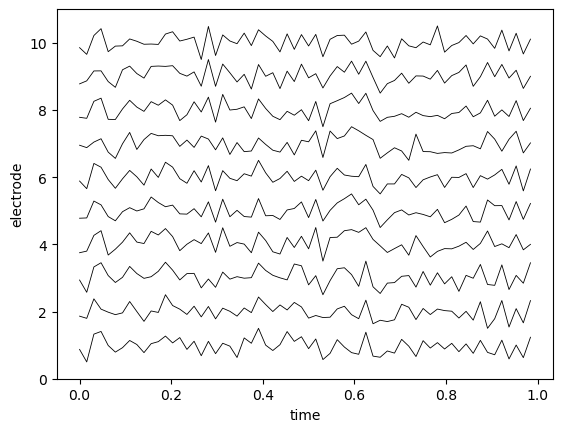

In [16]:
bo.plot_data()

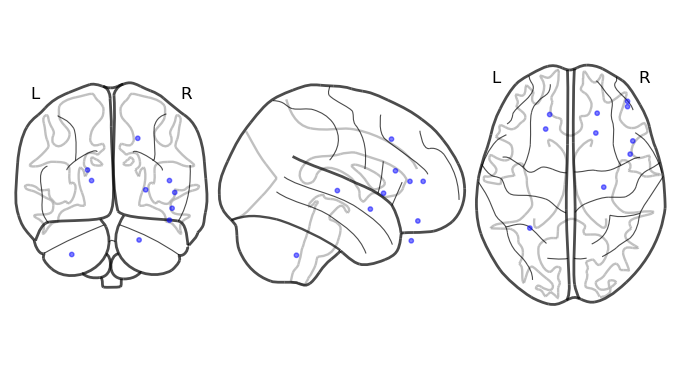

In [17]:
bo.plot_locs()

The other pieces of the brain object are listed below:

In [18]:
# array of session identifiers for each timepoint
sessions = bo.sessions

# number of sessions
n_sessions = bo.n_sessions

# sample rate
sample_rate = bo.sample_rate

# number of electrodes
n_elecs = bo.n_elecs

# length of each recording session in seconds
n_seconds = bo.dur

# the date and time that the bo was created
date_created = bo.date_created

# kurtosis of each electrode
kurtosis = bo.kurtosis

# meta data
meta = bo.meta

# label delinieating observed and reconstructed locations
label = bo.label

# Brain object methods

There are a few other useful methods on a brain object

## bo.info()

This method will give you a summary of the brain object:

In [19]:
bo.info()

Number of electrodes: 10
Recording time in seconds: [0.5 0.5]
Sample Rate in Hz: [64, 64]
Number of sessions: 2
Date created: Mon Jan 13 17:29:09 2025
Meta data: {'subjectID': '123', 'Investigator': 'Andy', 'Hospital': 'DHMC'}


## bo.apply_filter()

This method will return a filtered copy of the brain object.

In [20]:
bo_f = bo.apply_filter()

## bo.get_data()

In [21]:
data_array = bo.get_data()

## bo.get_zscore_data()

This method will return a numpy array of the zscored data:

In [22]:
zdata_array = bo.get_zscore_data()

## bo.get_locs()

This method will return a numpy array of the electrode locations:

In [23]:
locs = bo.get_locs()

## bo.get_slice()

This method allows you to slice out time and locations from the brain object, and returns a brain object. This can occur in place if you set the flag inplace=True.

In [24]:
bo_slice = bo.get_slice(sample_inds=None, loc_inds=None, inplace=False)

## bo.resample()

This method allows you resample a brain object in place.

In [25]:
bo.resample(resample_rate=None)

## bo.plot_data()

This method normalizes and plots data from brain object:

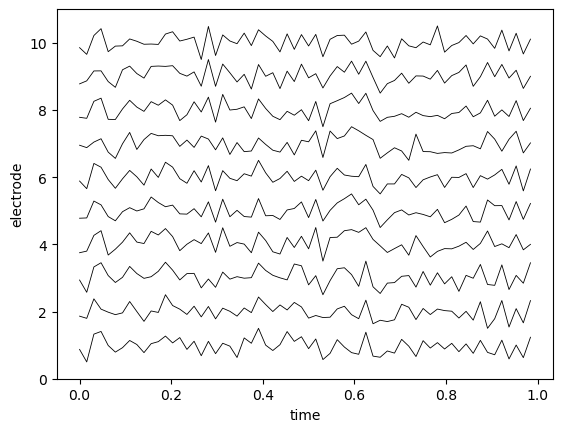

In [26]:
bo.plot_data()

## bo.plot_locs()

This method plots electrode locations from brain object:

In [27]:
bo_f = se.load('example_filter')

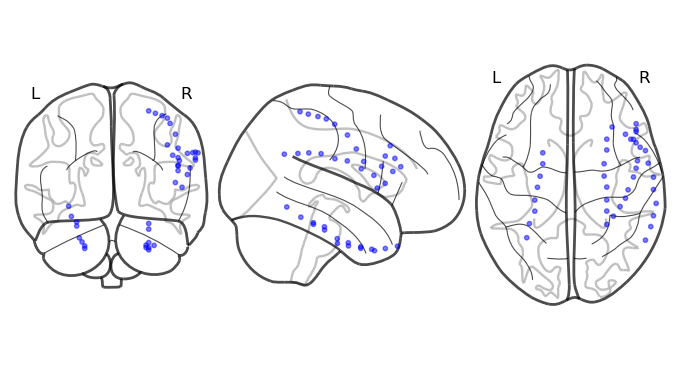

In [28]:
bo_f.plot_locs()

## bo.to_nii()

This method converts the brain object into supereeg’s nifti class (a subclass of the nibabel nifti class). If filepath is specified, the nifti file will be saved. You can also specify a nifti template with the template argument. If no template is specified, it will use the gray matter masked MNI 152 brain downsampled to 6mm.

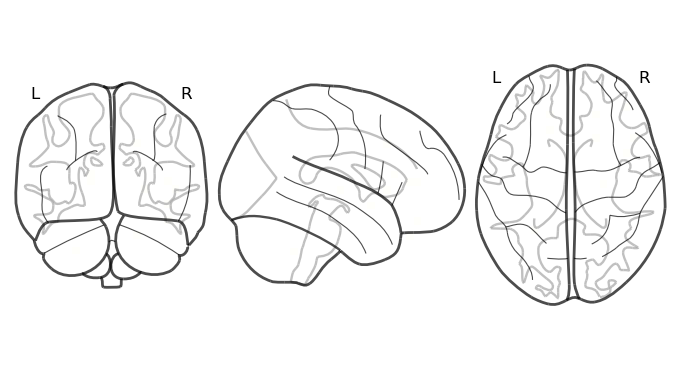

In [29]:
# convert to nifti
nii = bo.to_nii(template='gray', vox_size=6)

# plot first timepoint
nii.plot_glass_brain()

# save the file
# nii = bo.to_nii(filepath='~/Documents/supereeg/brain_object')

# specify a template and resolution
# nii = bo.to_nii(template='/path/to/nifti/file.nii', vox_size=20)

## bo.save(fname='something')

This method will save the brain object to the specified file location. The data will be saved as a ‘bo’ file, which is a dictionary containing the elements of a brain object saved in the hd5 format using deepdish.

In [30]:
bo.save(fname='brain_object')